In [13]:
import numpy as np
from scipy.linalg import sqrtm
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info import state_fidelity, DensityMatrix
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.opflow import StateFn, I, X, Y, Z, CircuitSampler, Gradient, PauliExpectation
from qiskit.algorithms.optimizers import GradientDescent, ADAM, L_BFGS_B
from qiskit.providers.aer import AerSimulator, extensions, QasmSimulator
from qiskit.providers.aer.noise import depolarizing_error, amplitude_damping_error, phase_damping_error, NoiseModel
import matplotlib.pyplot as plt

In [14]:
def get_fidelity(s1, s2):
    return state_fidelity(s1, s2)

pauli_y = np.array([[0, -1j], [1j, 0]])
krons = np.kron(pauli_y, pauli_y)

def get_concurrance(p):
    p = np.array(p)
    p_hat = np.matmul(np.matmul(krons, p.conj().T), krons)
    try:
        mat = sqrtm(np.matmul(np.matmul(sqrtm(p), p_hat), sqrtm(p)))
    except:
        return 0
    eigs = np.linalg.eigvals(mat)
    sorted_eigs = sorted(eigs, reverse=True)
    return max(0, sorted_eigs[0] - sorted_eigs[1] - sorted_eigs[2] - sorted_eigs[3])

In [15]:
def get_density_matrix(circuit, params, noise_model=NoiseModel()):
    c = circuit.bind_parameters(params)
    c.save_density_matrix()
    sim_noise = AerSimulator(noise_model=noise_model)
    result = sim_noise.run(c).result()
    density_matrix = result.data()['density_matrix']
    return density_matrix

# Two Qubit System

In [16]:
def make_circuit(version):
    circuit = QuantumCircuit(2)
    params = ParameterVector("theta", length=4 if version == 2 else 3)
    circuit.ry(params[0], 0)
    circuit.ry(params[1], 1)
    circuit.cx(0, 1)
    if version == 0:
        circuit.ry(params[2], 0)
    elif version == 1:
        circuit.ry(params[2], 1)
    elif version == 2:
        circuit.ry(params[2], 0)
        circuit.ry(params[3], 1)
    return circuit

In [17]:
hamiltonian = (Z ^ Z) + (X ^ I) + (I ^ X)
print(hamiltonian)

1.0 * ZZ
+ 1.0 * XI
+ 1.0 * IX


In [18]:
noises = [phase_damping_error, amplitude_damping_error, depolarizing_error]
gammas = np.linspace(0, 1, 100)
backend = Aer.get_backend('qasm_simulator')

0 0


/Users/owen.lockwood/miniconda3/envs/qiskit/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


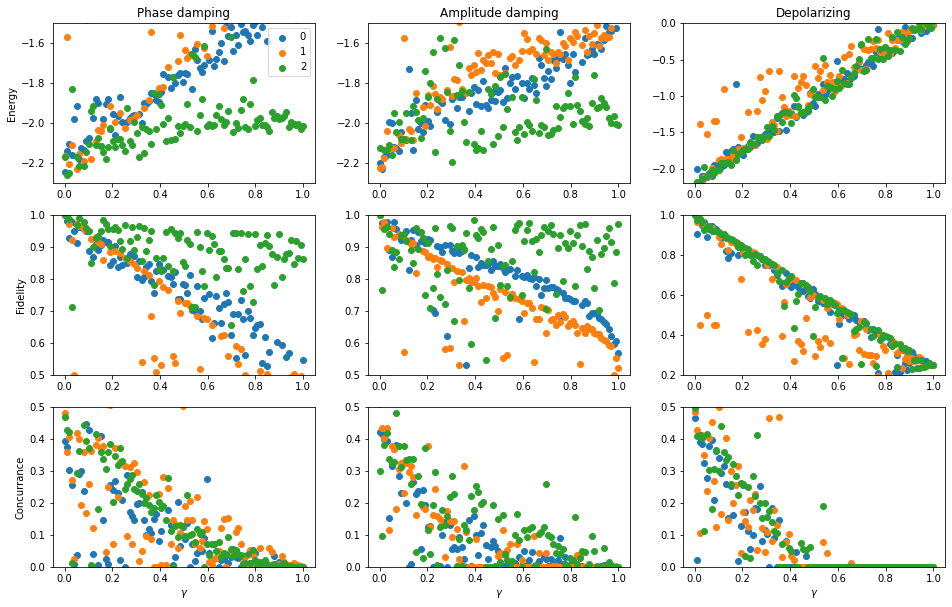

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))


for count, noise_type in enumerate(noises):
    for ver in range(3):
        print(count, ver)
        energies = []
        fidelities = []
        concurrances = []
        noiseless_solution = None
        for g in gammas:
            initial_point = np.random.uniform(0, 2 * np.pi, 4)
            def evaluate_expectation(x):
                value_dict = dict(zip(cir.parameters, x))
                result = sampler.convert(op, params=value_dict).eval()  
                return np.real(result)
            
            def evaluate_gradient(x):
                value_dict = dict(zip(cir.parameters, x))
                result = sampler.convert(gradient, params=value_dict).eval()
                return np.real(result)
            
            #print(noise_type, ver, g)
            params = 4 if ver == 2 else 3
            cir = make_circuit(ver)
            noise_model = NoiseModel()
            if g != 0:
                if count == 2:
                    noise = noise_type(g, 2)
                else:
                    noise = noise_type(g)
                    noise = noise.tensor(noise)
                noise_model.add_all_qubit_quantum_error(noise, ['cx'])
            q_instance = QuantumInstance(backend, noise_model=noise_model)
            sampler = CircuitSampler(q_instance)
            expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(cir)
            op = PauliExpectation().convert(expectation)
            
            gradient = Gradient(grad_method='param_shift').convert(op)
            #gd = GradientDescent(maxiter=100, learning_rate=0.05, tol=1e-4)
            #gd = ADAM(maxiter=80, lr=0.05)
            gd = L_BFGS_B()
            point, value, nfev = gd.optimize(params, evaluate_expectation, gradient_function=evaluate_gradient, initial_point=initial_point[:params]) 
            
            energies.append(value)
            
            if g == 0 and noiseless_solution is None:
                noiseless_solution = get_density_matrix(cir, point)
            current_density_matrix = get_density_matrix(cir, point, noise_model)
            fidelity = get_fidelity(noiseless_solution, current_density_matrix)
            
            fidelities.append(fidelity)
            
            concurrance = get_concurrance(current_density_matrix)
            
            concurrances.append(concurrance)
            
            
        axs[0, count].scatter(gammas, energies, label=str(ver))
        axs[1, count].scatter(gammas, fidelities)
        axs[2, count].scatter(gammas, concurrances)
        
axs[2, 0].set_xlabel("$\gamma$")
axs[2, 1].set_xlabel("$\gamma$")
axs[2, 2].set_xlabel("$\gamma$")
axs[0, 0].set_title('Phase damping')
axs[0, 1].set_title('Amplitude damping')
axs[0, 2].set_title('Depolarizing')
axs[0, 0].set_ylim(-2.3, -1.5)
axs[0, 1].set_ylim(-2.3, -1.5)
axs[0, 2].set_ylim(-2.2, 0)
axs[1, 0].set_ylim(0.5, 1)
axs[1, 1].set_ylim(0.5, 1)
axs[1, 2].set_ylim(0.2, 1)
axs[2, 0].set_ylim(0, 0.5)
axs[2, 1].set_ylim(0, 0.5)
axs[2, 2].set_ylim(0, 0.5)

axs[0, 0].legend()
axs[0, 0].set_ylabel("Energy")
axs[1, 0].set_ylabel("Fidelity")
axs[2, 0].set_ylabel("Concurrance")

plt.show()

# Four Qubit System

In [20]:
def make_circuit_four():
    circuit = QuantumCircuit(4)
    params = ParameterVector("theta", length=8)
    for i in range(4):
        circuit.ry(params[i], i)
    circuit.cx(0, 1)
    circuit.cx(1, 2)
    circuit.cx(2, 3)
    for i in range(4):
        circuit.ry(params[i + 4], i)
    return circuit

In [21]:
hamiltonian = (I ^ Z ^ I ^ Z) + 1/2 * ((I ^ I ^ X ^ X) + (I ^ I ^ Y ^ Y) + (X ^ X ^ I ^ I) + (Y ^ Y ^ I ^ I)) 
print(hamiltonian)

1.0 * IZIZ
+ 0.5 * IIXX
+ 0.5 * IIYY
+ 0.5 * XXII
+ 0.5 * YYII


In [22]:
noises = [phase_damping_error, amplitude_damping_error, depolarizing_error]
noise_names = ["Phase Damping", "Amplitude Damping", "Depolarizing"]
gammas = np.linspace(0, 1, 50)
backend = Aer.get_backend('qasm_simulator')

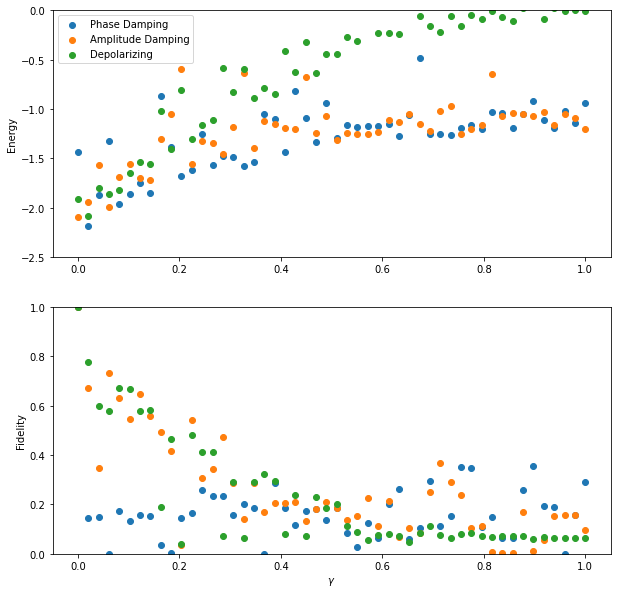

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))


for count, noise_type in enumerate(noises):
    energies = []
    fidelities = []
    noiseless_solution = None
    for g in gammas:
        initial_point = np.random.uniform(0, 2 * np.pi, 8)
        def evaluate_expectation(x):
            value_dict = dict(zip(cir.parameters, x))
            result = sampler.convert(op, params=value_dict).eval()  
            return np.real(result)

        def evaluate_gradient(x):
            value_dict = dict(zip(cir.parameters, x))
            result = sampler.convert(gradient, params=value_dict).eval()
            return np.real(result)

        #print(noise_type, g)
        cir = make_circuit_four()
        noise_model = NoiseModel()
        if g != 0:
            if count == 2:
                noise = noise_type(g, 2)
            else:
                noise = noise_type(g)
                noise = noise.tensor(noise)
            noise_model.add_all_qubit_quantum_error(noise, ['cx'])
        q_instance = QuantumInstance(backend, noise_model=noise_model)
        sampler = CircuitSampler(q_instance)
        expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(cir)
        op = PauliExpectation().convert(expectation)

        gradient = Gradient(grad_method='param_shift').convert(op)
        #gd = GradientDescent(maxiter=100, learning_rate=0.05, tol=1e-4)
        #gd = ADAM(maxiter=80, lr=0.05)
        gd = L_BFGS_B()
        point, value, nfev = gd.optimize(8, evaluate_expectation, gradient_function=evaluate_gradient, initial_point=initial_point) 

        energies.append(value)

        if g == 0 and noiseless_solution is None:
            noiseless_solution = get_density_matrix(cir, point)
        current_density_matrix = get_density_matrix(cir, point, noise_model)
        fidelity = get_fidelity(noiseless_solution, current_density_matrix)

        fidelities.append(fidelity)


    axs[0].scatter(gammas, energies, label=noise_names[count])
    axs[1].scatter(gammas, fidelities)

axs[1].set_xlabel("$\gamma$")
axs[0].set_ylim(-2.5, 0)
axs[1].set_ylim(0, 1)

axs[0].legend()
axs[0].set_ylabel("Energy")
axs[1].set_ylabel("Fidelity")

plt.show()

# Parameter Degeneracies

In [24]:
def make_circuit_one():
    circuit = QuantumCircuit(1)
    params = ParameterVector("theta", length=2)
    circuit.ry(params[0], 0, label='first')
    circuit.ry(params[1], 0)
    return circuit

In [25]:
hamiltonian = Z 

Z


In [26]:
gamma = 0.4
backend = Aer.get_backend('qasm_simulator')

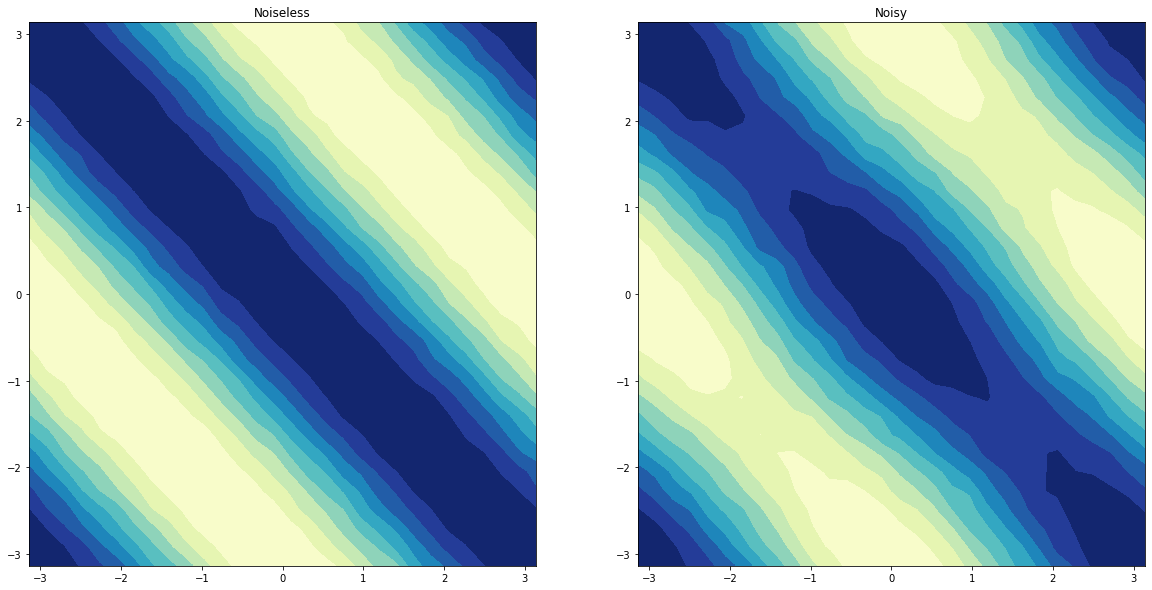

In [37]:
def evaluate_expectation(x):
    value_dict = dict(zip(cir.parameters, x))
    result = sampler.convert(op, params=value_dict).eval()  
    return np.real(result)

cir = make_circuit_one()
noise_model = NoiseModel()
#noise = depolarizing_error(gamma, 1)
noise = phase_damping_error(gamma)
noise_model.add_all_qubit_quantum_error(noise, ['first'])
q_instance = QuantumInstance(backend, noise_model=noise_model)
sampler = CircuitSampler(q_instance)
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(cir)
op = PauliExpectation().convert(expectation)

N = 30
xs = np.linspace(-np.pi, np.pi, N)
ys = np.linspace(-np.pi, np.pi, N)
zs = np.zeros(shape=(N, N))
for i in range(len(xs)):
    #print(i)
    for j in range(len(ys)):
        zs[i][j] = evaluate_expectation([xs[i], ys[j]])
           
cir = make_circuit_one()
q_instance = QuantumInstance(backend)
sampler = CircuitSampler(q_instance)
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(cir)
op = PauliExpectation().convert(expectation)

xs = np.linspace(-np.pi, np.pi, N)
ys = np.linspace(-np.pi, np.pi, N)
zs1 = np.zeros(shape=(N, N))
for i in range(len(xs)):
    #print(i)
    for j in range(len(ys)):
        zs1[i][j] = evaluate_expectation([xs[i], ys[j]])

# Label axes
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[1].contourf(xs, ys, zs, 10, cmap='YlGnBu')
#axs[1].contour(xs, ys, zs, 30, cmap='cool')
axs[1].set_title("Noisy")
axs[0].contourf(xs, ys, zs1, 10, cmap='YlGnBu')
#axs[0].contour(xs, ys, zs1, 30, cmap='cool')
axs[0].set_title("Noiseless")
plt.show()

# Random Target State

In [28]:
def make_circuit_layers(l):
    circuit = QuantumCircuit(4)
    params = ParameterVector("theta", length=4 * l)
    counter = 0
    for i in range(l):
        for j in range(4):
            circuit.ry(params[counter], j)
            counter += 1
        circuit.cx(0, 1, label='first')
        circuit.cx(2, 3)
        circuit.cx(1, 2, label='second')
    return circuit

In [29]:
noises = [phase_damping_error, amplitude_damping_error, depolarizing_error]
gammas = [0, 1e-3, 1e-2, 5 * 1e-2, 1e-1]
layers = [i for i in range(1, 7)]
backend = Aer.get_backend('qasm_simulator')

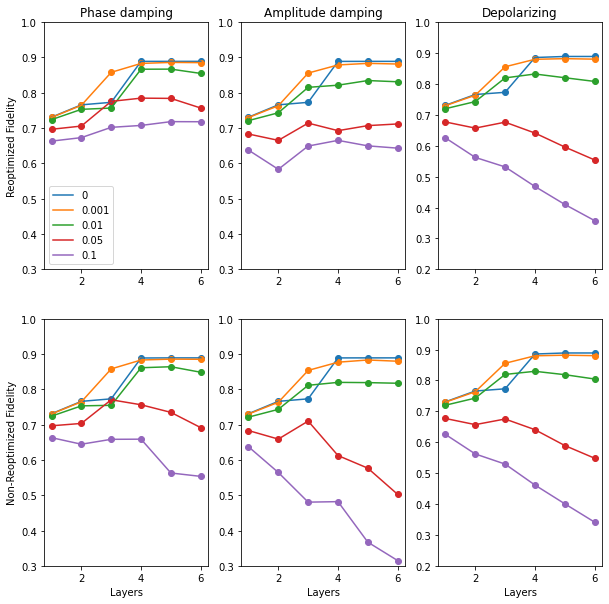

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

target_state = np.random.uniform(0, 1, (1, 2**4)) + np.random.uniform(0, 1, (1, 2**4)) * 1j
target_state = target_state / np.linalg.norm(target_state)
target_dm = np.matmul(target_state.conj().T, target_state)

for count, noise_type in enumerate(noises):
    for g in gammas:
        reopts = []
        non_reopts = []
        for lay in layers:
            initial_point = np.random.uniform(0, 2 * np.pi, lay * 4)
            def evaluate_expectation_noiseless(x):
                fid = get_fidelity(target_dm, get_density_matrix(cir, x))
                return 1 - fid
            
            def evaluate_expectation_noisy(x):
                fid = get_fidelity(target_dm, get_density_matrix(cir, x, noise_model))
                return 1 - fid
            
            cir = make_circuit_layers(lay)
            noise_model = NoiseModel()
            no_noise = NoiseModel()
            if g != 0:
                if count == 2:
                    noise = noise_type(g, 2)
                else:
                    noise = noise_type(g)
                    noise = noise.tensor(noise)
                noise_model.add_all_qubit_quantum_error(noise, ['first', 'second'])

            gd = L_BFGS_B()
            point, value, nfev = gd.optimize(initial_point.size, evaluate_expectation_noiseless, initial_point=initial_point) 

            current_density_matrix = get_density_matrix(cir, point, noise_model)
            fidelity = get_fidelity(target_dm, current_density_matrix)
            non_reopts.append(fidelity)
            
            gd = L_BFGS_B()
            point, value, nfev = gd.optimize(initial_point.size, evaluate_expectation_noisy, initial_point=point) 

            current_density_matrix = get_density_matrix(cir, point, noise_model)
            fidelity = get_fidelity(target_dm, current_density_matrix)
            
            reopts.append(fidelity)

        axs[0, count].plot(layers, reopts, label=str(g))
        axs[0, count].scatter(layers, reopts)
        axs[1, count].plot(layers, non_reopts)
        axs[1, count].scatter(layers, non_reopts)

axs[1, 0].set_xlabel("Layers")
axs[1, 1].set_xlabel("Layers")
axs[1, 2].set_xlabel("Layers")
axs[0, 0].set_title('Phase damping')
axs[0, 1].set_title('Amplitude damping')
axs[0, 2].set_title('Depolarizing')
axs[0, 0].set_ylim(0.3, 1)
axs[0, 1].set_ylim(0.3, 1)
axs[0, 2].set_ylim(0.2, 1)
axs[1, 0].set_ylim(0.3, 1)
axs[1, 1].set_ylim(0.3, 1)
axs[1, 2].set_ylim(0.2, 1)

axs[0, 0].legend()
axs[0, 0].set_ylabel("Reoptimized Fidelity")
axs[1, 0].set_ylabel("Non-Reoptimized Fidelity")

plt.show()

In [2]:
from qiskit.tools.jupyter import *

%qiskit_version_table